# IMPORT LIBRARIES AND SETUP
This cell imports all necessary libraries and sets up the visualization styles. It's the foundation for the entire analysis

In [5]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("COMPREHENSIVE RAINFALL ANALYSIS (2000-2024)")
print("=" * 80)

COMPREHENSIVE RAINFALL ANALYSIS (2000-2024)


# DATA LOADING AND INITIAL CHECK
This cell loads your data and provides an initial overview. You should adjust the data loading based on your actual data source

In [6]:

# Assuming df is already loaded from the previous step
# If not, uncomment and update the line below:
# df = pd.read_csv('output.csv')

print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['year'].min()} to {df['year'].max()}")
print(f"Unique locations: {df['id_number'].nunique()}")

Data shape: (56810, 13)
Columns: ['system:index', '@id', 'id', 'id_number', 'month', 'rainfall_mm', 'sum', 'year', '.geo', 'quarter', 'season', 'month_name', 'is_rainy']
Date range: 2000 to 2024
Unique locations: 190


# DATA PREPARATION AND FEATURE ENGINEERING
This cell creates temporal features (quarter, season, month names) and separates rainy vs dry days for more detailed analysis.

In [8]:
#===========================================================================

print("\n1. PREPARING DATA...")

# Create additional time-based features
df['quarter'] = df['month'].apply(lambda x: f"Q{(x-1)//3 + 1}")
df['season'] = df['month'].apply(lambda x: 
    'DJF' if x in [12, 1, 2] else
    'MAM' if x in [3, 4, 5] else
    'JJA' if x in [6, 7, 8] else 'SON')

month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df['month_name'] = df['month'].map(month_names)

# Separate rainy days (>0mm) from dry days
df['is_rainy'] = df['rainfall_mm'] > 0
rainy_days = df[df['is_rainy']]

print(f"✓ Enhanced dataset created")
print(f"  - Total records: {len(df):,}")
print(f"  - Rainy days (>0mm): {len(rainy_days):,} ({len(rainy_days)/len(df)*100:.1f}%)")
print(f"  - Dry days (0mm): {len(df) - len(rainy_days):,} ({(len(df) - len(rainy_days))/len(df)*100:.1f}%)")


1. PREPARING DATA...
✓ Enhanced dataset created
  - Total records: 56,810
  - Rainy days (>0mm): 6,650 (11.7%)
  - Dry days (0mm): 50,160 (88.3%)


# OVERALL STATISTICS
Provides basic statistical summaries for all days and rainy days only, giving an overview of the rainfall distribution

In [9]:
print("\n" + "=" * 80)
print("2. OVERALL STATISTICS")
print("=" * 80)

print("\nAll days (including dry days):")
print(df['rainfall_mm'].describe())

print("\nRainy days only (>0mm):")
if len(rainy_days) > 0:
    print(rainy_days['rainfall_mm'].describe())


2. OVERALL STATISTICS

All days (including dry days):
count    56810.000000
mean         0.649123
std         14.270531
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        914.134208
Name: rainfall_mm, dtype: float64

Rainy days only (>0mm):
count    6650.000000
mean        5.545366
std        41.386131
min         0.001165
25%         0.063862
50%         0.189774
75%         0.543459
max       914.134208
Name: rainfall_mm, dtype: float64


# LOCATION ANALYSIS - STATISTICS
Aggregates rainfall statistics by location, showing the wettest and driest locations in your dataset.

In [10]:
# ============================================================================

print("\n" + "=" * 80)
print("3. LOCATION ANALYSIS")
print("=" * 80)

# Statistics by location
location_stats = df.groupby('id_number').agg({
    'rainfall_mm': ['count', 'sum', 'mean', 'median', 'std', 'min', 'max'],
    'is_rainy': 'sum'
}).round(2)

location_stats.columns = ['Records', 'Total_Rain', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Rainy_Days']
location_stats['Rainy_Days_%'] = (location_stats['Rainy_Days'] / location_stats['Records'] * 100).round(1)
location_stats = location_stats.sort_values('Total_Rain', ascending=False)

print("\nTop 15 locations by total rainfall:")
print(location_stats.head(15))

print("\nBottom 10 locations (driest):")
print(location_stats.tail(10))


3. LOCATION ANALYSIS

Top 15 locations by total rainfall:
            Records  Total_Rain    Mean  Median     Std   Min     Max  \
id_number                                                               
4720446         299    34393.03  115.03   33.74  160.05  0.00  914.13   
850661516       299      370.03    1.24    0.50    1.72  0.00    9.53   
830402251       299      324.07    1.08    0.45    1.47  0.00    7.97   
850661503       299      161.83    0.54    0.21    0.75  0.00    4.06   
850793064       299      107.89    0.36    0.14    0.50  0.00    2.71   
850815686       299      105.13    0.35    0.14    0.49  0.00    2.83   
582500805       299       93.08    0.31    0.16    0.38  0.02    2.11   
585340662       299       78.23    0.26    0.12    0.33  0.00    1.76   
585097422       299       76.09    0.25    0.12    0.32  0.00    1.78   
1189002593      299       73.85    0.25    0.08    0.36  0.00    2.28   
571838781       299       72.38    0.24    0.11    0.31  0.00    

# YEARLY TRENDS - STATISTICS
Analyzes rainfall patterns over years and identifies the wettest and driest years

In [11]:

print("\n" + "=" * 80)
print("4. YEARLY TRENDS")
print("=" * 80)

yearly_stats = df.groupby('year').agg({
    'rainfall_mm': ['count', 'sum', 'mean', 'median'],
    'is_rainy': 'sum'
}).round(2)

yearly_stats.columns = ['Records', 'Total', 'Mean', 'Median', 'Rainy_Days']
yearly_stats['Rainy_Days_%'] = (yearly_stats['Rainy_Days'] / yearly_stats['Records'] * 100).round(1)

print("\nYearly rainfall statistics:")
print(yearly_stats)

# Identify wettest and driest years
wettest_year = yearly_stats['Total'].idxmax()
driest_year = yearly_stats['Total'].idxmin()
print(f"\n📊 Wettest year: {wettest_year} ({yearly_stats.loc[wettest_year, 'Total']:.2f} mm total)")
print(f"📊 Driest year: {driest_year} ({yearly_stats.loc[driest_year, 'Total']:.2f} mm total)")


4. YEARLY TRENDS

Yearly rainfall statistics:
      Records    Total  Mean  Median  Rainy_Days  Rainy_Days_%
year                                                          
2000     2280  1541.45  0.68     0.0         245          10.7
2001     2280  1610.88  0.71     0.0         261          11.4
2002     2280  1586.81  0.70     0.0         251          11.0
2003     2280   956.31  0.42     0.0         253          11.1
2004     2280  1375.77  0.60     0.0         257          11.3
2005     2280   723.50  0.32     0.0         250          11.0
2006     2280  2421.79  1.06     0.0         256          11.2
2007     2280   883.64  0.39     0.0         264          11.6
2008     2280  1171.39  0.51     0.0         259          11.4
2009     2280  1139.37  0.50     0.0         252          11.1
2010     2280  1523.20  0.67     0.0         272          11.9
2011     2280  1328.47  0.58     0.0         256          11.2
2012     2280  1313.19  0.58     0.0         256          11.2
2013    

# MONTHLY PATTERNS - STATISTICS
Analyzes rainfall patterns by month across all years in the dataset.

In [12]:

print("\n" + "=" * 80)
print("5. MONTHLY PATTERNS")
print("=" * 80)

monthly_stats = df.groupby('month').agg({
    'rainfall_mm': ['count', 'sum', 'mean', 'median', 'std'],
    'is_rainy': 'sum'
}).round(2)

monthly_stats.columns = ['Records', 'Total', 'Mean', 'Median', 'Std', 'Rainy_Days']
monthly_stats['Rainy_Days_%'] = (monthly_stats['Rainy_Days'] / monthly_stats['Records'] * 100).round(1)
monthly_stats.index = [month_names[i] for i in monthly_stats.index]

print("\nMonthly rainfall patterns (across all years):")
print(monthly_stats)

wettest_month = monthly_stats['Total'].idxmax()
driest_month = monthly_stats['Total'].idxmin()
print(f"\n📊 Wettest month: {wettest_month} ({monthly_stats.loc[wettest_month, 'Total']:.2f} mm total)")


5. MONTHLY PATTERNS

Monthly rainfall patterns (across all years):
     Records     Total  Mean  Median    Std  Rainy_Days  Rainy_Days_%
Jan     4750   1635.55  0.34     0.0   6.18         692          14.6
Feb     4750   1174.68  0.25     0.0   3.91         675          14.2
Mar     4750   4862.99  1.02     0.0  16.32         700          14.7
Apr     4750   6587.87  1.39     0.0  19.66         700          14.7
May     4750   1584.98  0.33     0.0   4.78         700          14.7
Jun     4750     93.10  0.02     0.0   0.40         317           6.7
Jul     4750    272.22  0.06     0.0   1.01         308           6.5
Aug     4750    382.61  0.08     0.0   1.20         236           5.0
Sep     4750    340.06  0.07     0.0   1.05         250           5.3
Oct     4750   1284.45  0.27     0.0   5.02         700          14.7
Nov     4750  10409.46  2.19     0.0  30.89         700          14.7
Dec     4560   8248.71  1.81     0.0  27.35         672          14.7

📊 Wettest month: Nov 

# MONTHLY PATTERNS - VISUALIZATIONS
Creates four visualizations showing monthly rainfall patterns, including a heatmap of year vs month

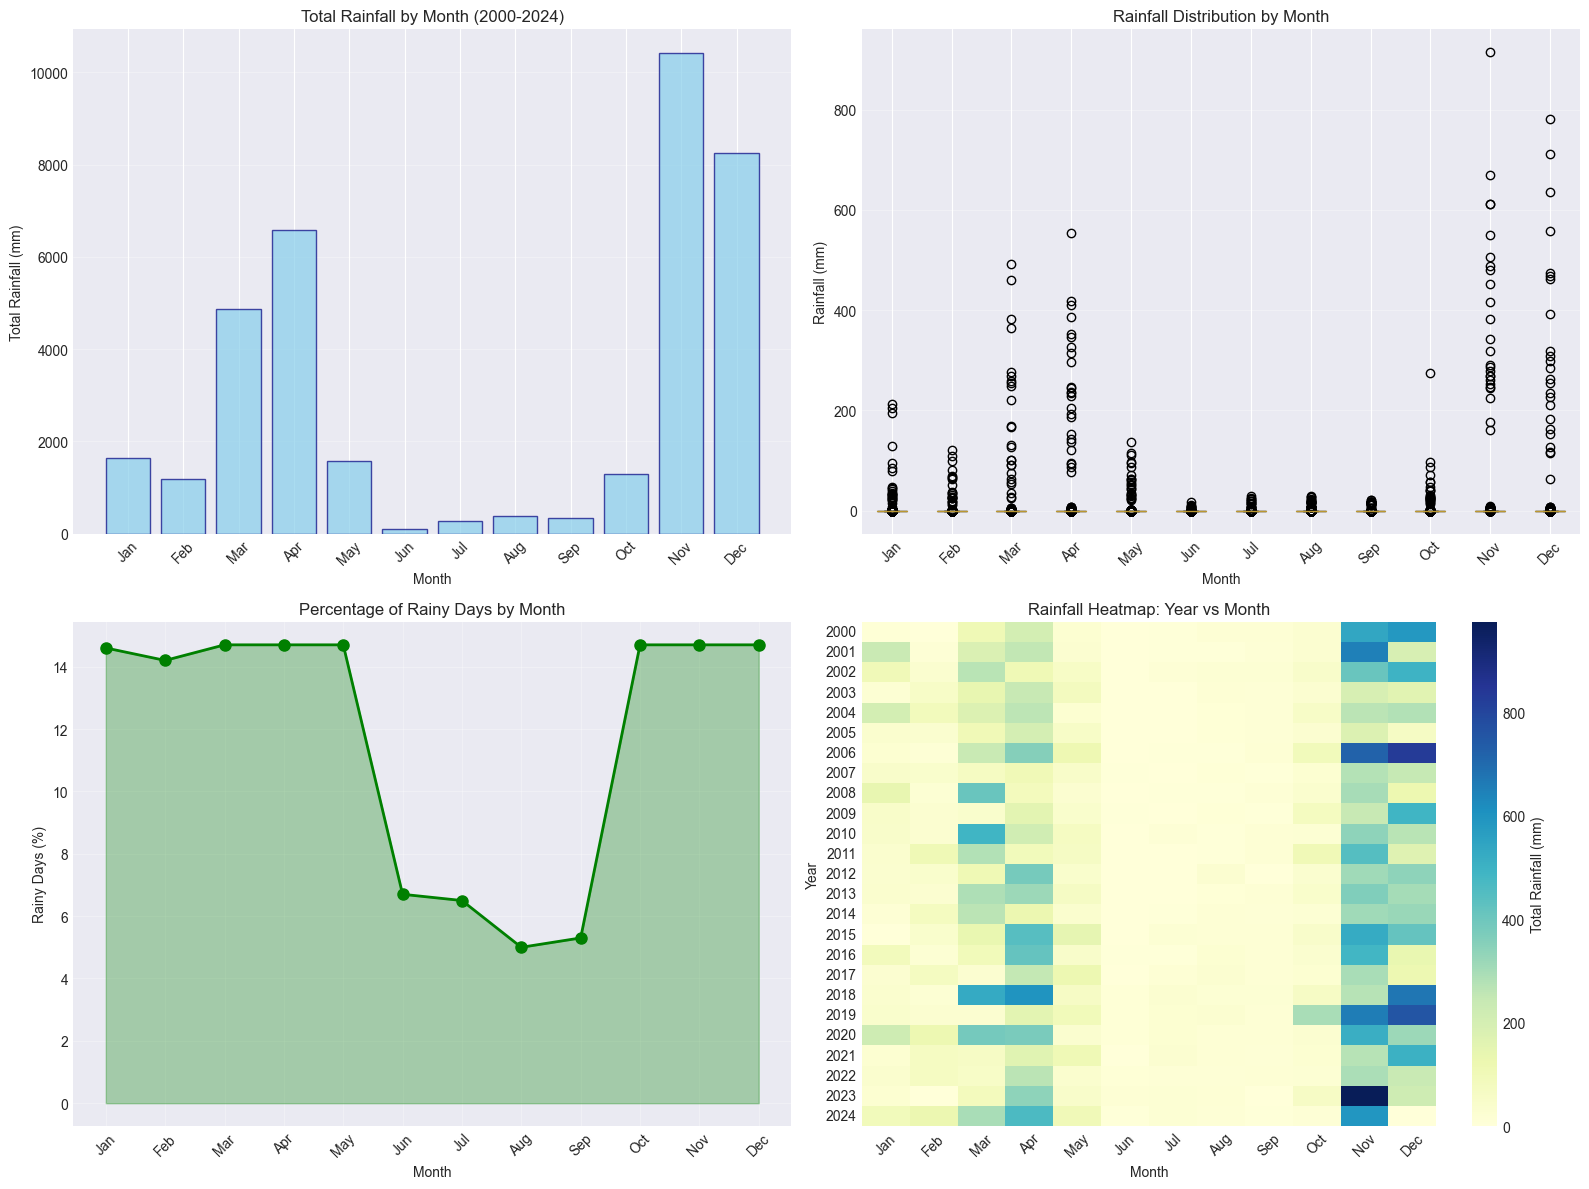

In [13]:

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total rainfall by month
months_order = list(month_names.values())
axes[0, 0].bar(months_order, [monthly_stats.loc[m, 'Total'] for m in months_order], 
               color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Rainfall (mm)')
axes[0, 0].set_title('Total Rainfall by Month (2000-2024)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Box plot - rainfall distribution by month
month_data = [df[df['month']==i]['rainfall_mm'].values for i in range(1, 13)]
bp = axes[0, 1].boxplot(month_data, labels=months_order, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Rainfall (mm)')
axes[0, 1].set_title('Rainfall Distribution by Month')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Rainy days percentage by month
axes[1, 0].plot(months_order, [monthly_stats.loc[m, 'Rainy_Days_%'] for m in months_order], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 0].fill_between(range(len(months_order)), 
                         [monthly_stats.loc[m, 'Rainy_Days_%'] for m in months_order], 
                         alpha=0.3, color='green')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Rainy Days (%)')
axes[1, 0].set_title('Percentage of Rainy Days by Month')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Heatmap: Year vs Month (total rainfall)
pivot_data = df.groupby(['year', 'month'])['rainfall_mm'].sum().unstack(fill_value=0)
sns.heatmap(pivot_data, cmap='YlGnBu', ax=axes[1, 1], cbar_kws={'label': 'Total Rainfall (mm)'})
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Year')
axes[1, 1].set_title('Rainfall Heatmap: Year vs Month')
axes[1, 1].set_xticklabels(months_order, rotation=45)

plt.tight_layout()
plt.show()

# QUARTERLY ANALYSIS
Analyzes rainfall patterns by quarter and shows how quarterly rainfall has changed over the years.


6. QUARTERLY ANALYSIS

Quarterly rainfall patterns:
         Records     Total  Mean  Median  Rainy_Days  Rainy_Days_%
quarter                                                           
Q1         14250   7673.22  0.54     0.0        2067          14.5
Q2         14250   8265.95  0.58     0.0        1717          12.0
Q3         14250    994.89  0.07     0.0         794           5.6
Q4         14060  19942.62  1.42     0.0        2072          14.7


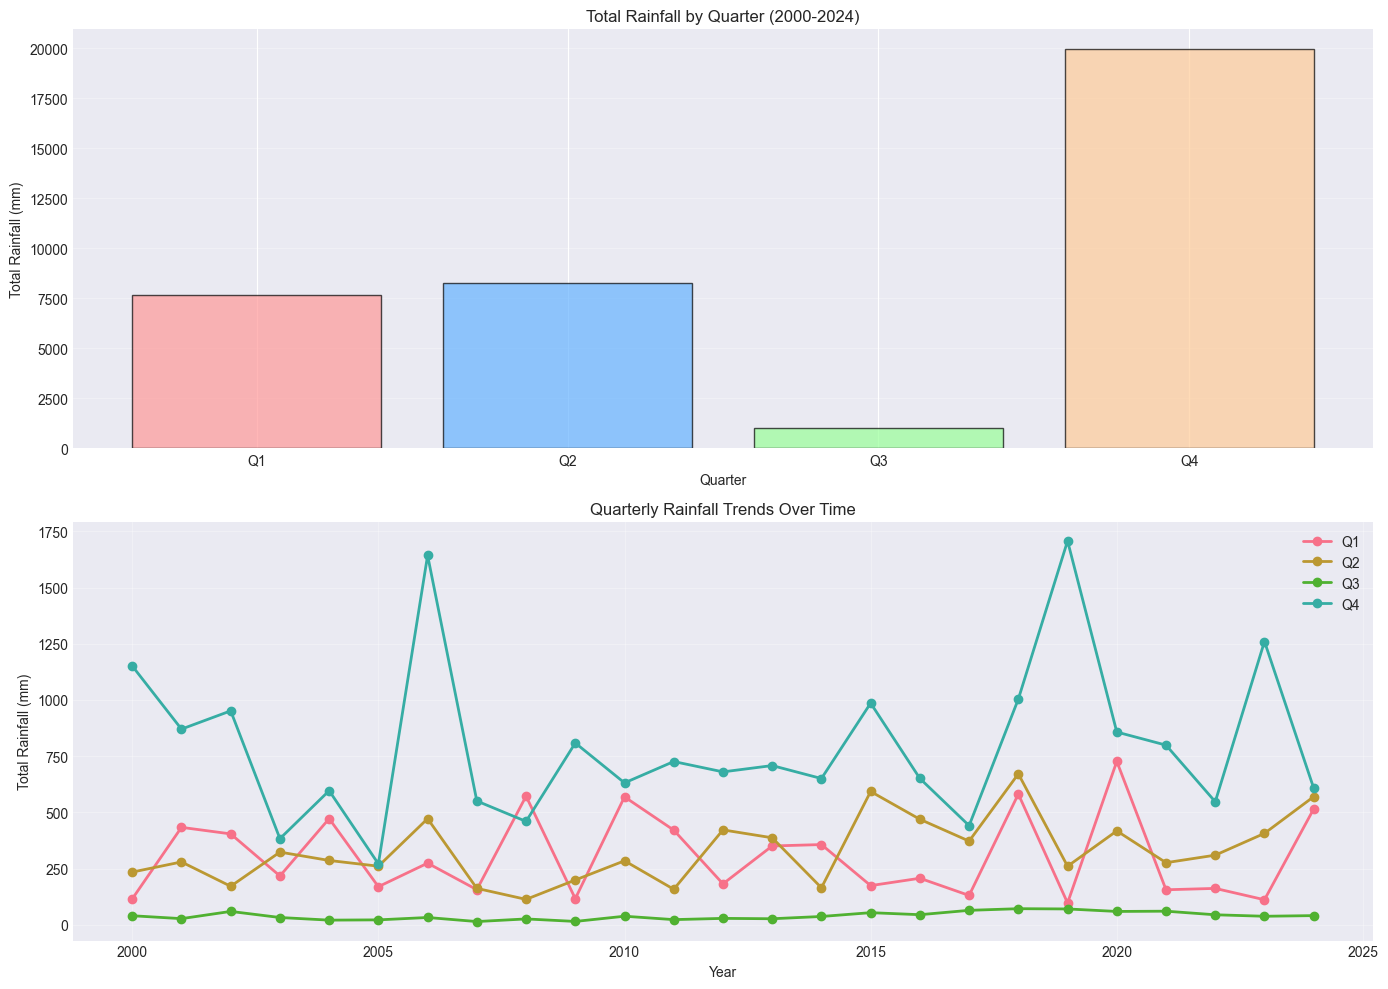

In [14]:
# ============================================================================
# CELL 11: QUARTERLY ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("6. QUARTERLY ANALYSIS")
print("=" * 80)

quarterly_stats = df.groupby('quarter').agg({
    'rainfall_mm': ['count', 'sum', 'mean', 'median'],
    'is_rainy': 'sum'
}).round(2)

quarterly_stats.columns = ['Records', 'Total', 'Mean', 'Median', 'Rainy_Days']
quarterly_stats['Rainy_Days_%'] = (quarterly_stats['Rainy_Days'] / quarterly_stats['Records'] * 100).round(1)

print("\nQuarterly rainfall patterns:")
print(quarterly_stats)

# Quarterly trends over years
quarterly_yearly = df.groupby(['year', 'quarter'])['rainfall_mm'].sum().unstack(fill_value=0)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Average by quarter
quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
axes[0].bar(quarter_order, [quarterly_stats.loc[q, 'Total'] for q in quarter_order], 
            color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Total Rainfall (mm)')
axes[0].set_title('Total Rainfall by Quarter (2000-2024)')
axes[0].grid(True, alpha=0.3, axis='y')

# Quarterly trends over time
for q in quarter_order:
    if q in quarterly_yearly.columns:
        axes[1].plot(quarterly_yearly.index, quarterly_yearly[q], marker='o', label=q, linewidth=2)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Rainfall (mm)')
axes[1].set_title('Quarterly Rainfall Trends Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SEASONAL ANALYSIS
Analyzes rainfall patterns by meteorological seasons (DJF, MAM, JJA, SON)


7. SEASONAL ANALYSIS

Seasonal rainfall patterns:
        Records     Total  Mean  Median  Rainy_Days  Rainy_Days_%
season                                                           
DJF       14060  11058.95  0.79     0.0        2039          14.5
MAM       14250  13035.84  0.91     0.0        2100          14.7
JJA       14250    747.93  0.05     0.0         861           6.0
SON       14250  12033.97  0.84     0.0        1650          11.6


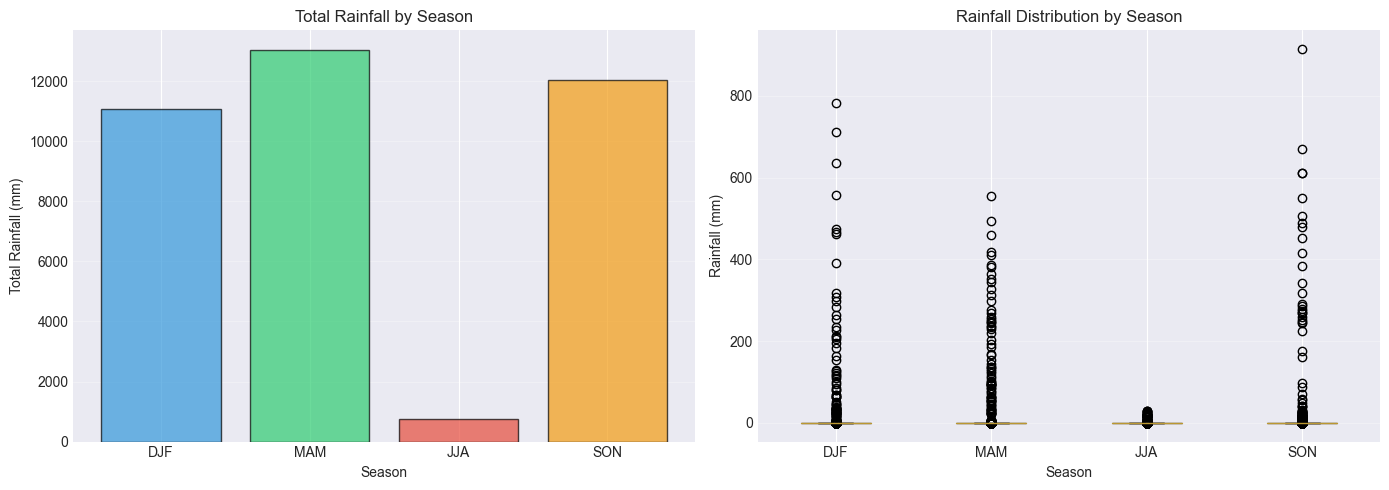

In [15]:
# ==========================================================================

print("\n" + "=" * 80)
print("7. SEASONAL ANALYSIS")
print("=" * 80)

seasonal_stats = df.groupby('season').agg({
    'rainfall_mm': ['count', 'sum', 'mean', 'median'],
    'is_rainy': 'sum'
}).round(2)

seasonal_stats.columns = ['Records', 'Total', 'Mean', 'Median', 'Rainy_Days']
seasonal_stats['Rainy_Days_%'] = (seasonal_stats['Rainy_Days'] / seasonal_stats['Records'] * 100).round(1)

season_order = ['DJF', 'MAM', 'JJA', 'SON']
seasonal_stats = seasonal_stats.reindex(season_order)

print("\nSeasonal rainfall patterns:")
print(seasonal_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors_season = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
axes[0].bar(season_order, [seasonal_stats.loc[s, 'Total'] for s in season_order], 
            color=colors_season, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Total Rainfall (mm)')
axes[0].set_title('Total Rainfall by Season')
axes[0].grid(True, alpha=0.3, axis='y')

season_data = [df[df['season']==s]['rainfall_mm'].values for s in season_order]
bp = axes[1].boxplot(season_data, labels=season_order, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_season):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Rainfall (mm)')
axes[1].set_title('Rainfall Distribution by Season')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ABNORMALITY DETECTION
Identifies extreme rainfall events using statistical methods (Z-scores and percentiles).

In [16]:
# ============================================================================
# CELL 13: ABNORMALITY DETECTION
# ============================================================================

print("\n" + "=" * 80)
print("8. ABNORMALITY DETECTION")
print("=" * 80)

# Calculate Z-scores (only for rainy days to avoid skew from zeros)
if len(rainy_days) > 0:
    rainy_days_copy = rainy_days.copy()
    rainy_days_copy['z_score'] = np.abs(stats.zscore(rainy_days_copy['rainfall_mm']))
    
    # Identify extreme events
    extreme_rain = rainy_days_copy[rainy_days_copy['z_score'] > 3].sort_values('rainfall_mm', ascending=False)
    
    print(f"\nExtreme rainfall events (>3 std dev from mean):")
    print(f"Total extreme events: {len(extreme_rain)} ({len(extreme_rain)/len(rainy_days)*100:.2f}% of rainy days)")
    
    print("\nTop 20 extreme rainfall events:")
    print(extreme_rain[['id_number', 'year', 'month_name', 'rainfall_mm', 'z_score']].head(20))

# Percentile-based abnormalities
percentile_95 = df['rainfall_mm'].quantile(0.95)
percentile_99 = df['rainfall_mm'].quantile(0.99)

print(f"\n95th percentile: {percentile_95:.2f} mm")
print(f"99th percentile: {percentile_99:.2f} mm")

heavy_rain_95 = df[df['rainfall_mm'] > percentile_95]
heavy_rain_99 = df[df['rainfall_mm'] > percentile_99]

print(f"Events above 95th percentile: {len(heavy_rain_95):,}")
print(f"Events above 99th percentile: {len(heavy_rain_99):,}")


8. ABNORMALITY DETECTION

Extreme rainfall events (>3 std dev from mean):
Total extreme events: 84 (1.26% of rainy days)

Top 20 extreme rainfall events:
       id_number  year month_name  rainfall_mm    z_score
54340    4720446  2023        Nov   914.134208  21.955596
15770    4720446  2006        Dec   781.432849  18.748934
45410    4720446  2019        Dec   711.641679  17.062465
15580    4720446  2006        Nov   669.665472  16.048131
43130    4720446  2018        Dec   636.387175  15.243977
45220    4720446  2019        Nov   612.158920  14.658514
4180     4720446  2001        Nov   611.049231  14.631699
2090     4720446  2000        Dec   556.849096  13.321979
41610    4720446  2018        Apr   554.753787  13.271347
56620    4720446  2024        Nov   550.338098  13.164644
1900     4720446  2000        Nov   506.682638  12.109732
41420    4720446  2018        Mar   492.710172  11.772094
36100    4720446  2015        Nov   488.726680  11.675835
47500    4720446  2020        Nov

# ABNORMALITY DETECTION - VISUALIZATIONS
Visualizes extreme rainfall events and their patterns over time and across locations.

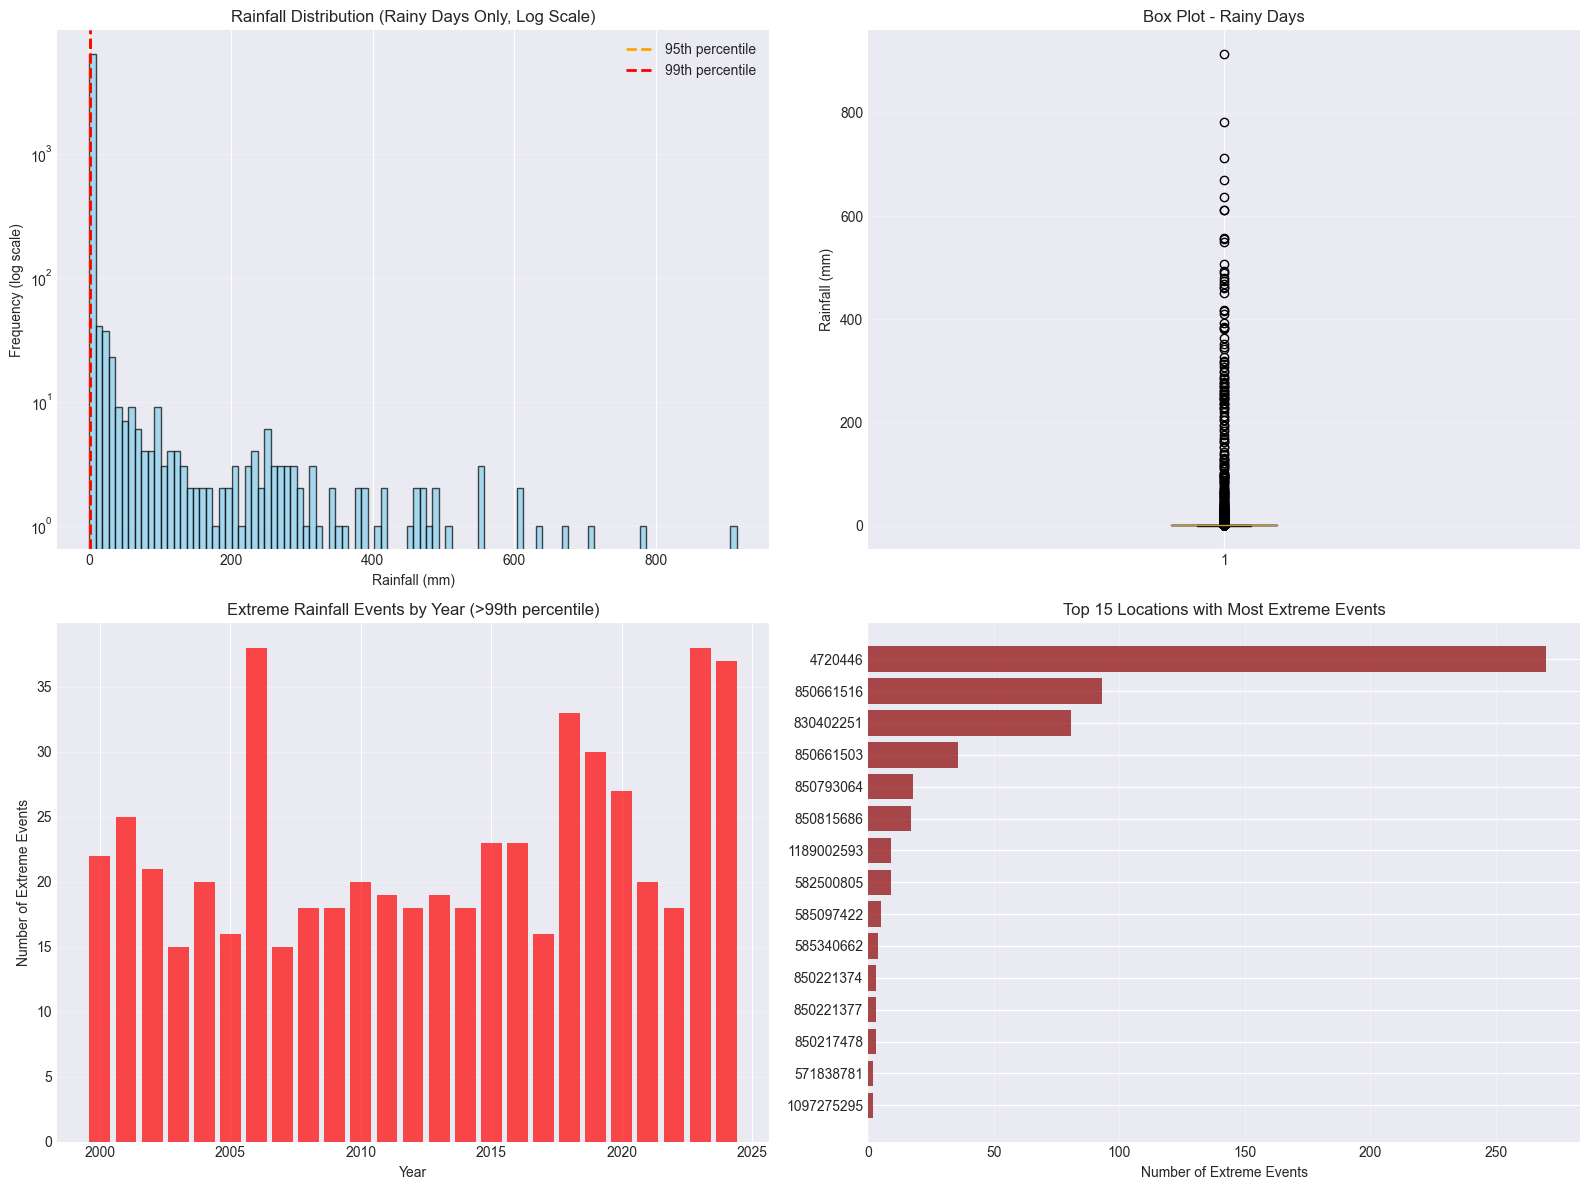

In [17]:
# ============================================================================
# CELL 14: ABNORMALITY DETECTION - VISUALIZATIONS
# ============================================================================

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution (log scale for better visualization)
rainy_values = df[df['rainfall_mm'] > 0]['rainfall_mm']
axes[0, 0].hist(rainy_values, bins=100, alpha=0.7, color='skyblue', edgecolor='black', log=True)
axes[0, 0].axvline(percentile_95, color='orange', linestyle='--', linewidth=2, label='95th percentile')
axes[0, 0].axvline(percentile_99, color='red', linestyle='--', linewidth=2, label='99th percentile')
axes[0, 0].set_xlabel('Rainfall (mm)')
axes[0, 0].set_ylabel('Frequency (log scale)')
axes[0, 0].set_title('Rainfall Distribution (Rainy Days Only, Log Scale)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Box plot showing outliers
axes[0, 1].boxplot(rainy_values, vert=True)
axes[0, 1].set_ylabel('Rainfall (mm)')
axes[0, 1].set_title('Box Plot - Rainy Days')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Extreme events over time
extreme_by_year = heavy_rain_99.groupby('year').size()
axes[1, 0].bar(extreme_by_year.index, extreme_by_year.values, color='red', alpha=0.7)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Extreme Events')
axes[1, 0].set_title('Extreme Rainfall Events by Year (>99th percentile)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Extreme events by location (top 15)
extreme_by_location = heavy_rain_99.groupby('id_number').size().sort_values(ascending=False).head(15)
axes[1, 1].barh(range(len(extreme_by_location)), extreme_by_location.values, color='darkred', alpha=0.7)
axes[1, 1].set_yticks(range(len(extreme_by_location)))
axes[1, 1].set_yticklabels(extreme_by_location.index)
axes[1, 1].set_xlabel('Number of Extreme Events')
axes[1, 1].set_title('Top 15 Locations with Most Extreme Events')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# DROUGHT ANALYSIS
Analyzes drought conditions by calculating consecutive dry spells and identifying drought years.

In [18]:

# ============================================================================

print("\n" + "=" * 80)
print("9. DROUGHT ANALYSIS")
print("=" * 80)

# Consecutive dry days analysis by location
def count_dry_spells(group):
    dry_spells = []
    current_spell = 0
    for val in group['rainfall_mm'].values:
        if val == 0:
            current_spell += 1
        else:
            if current_spell > 0:
                dry_spells.append(current_spell)
            current_spell = 0
    if current_spell > 0:
        dry_spells.append(current_spell)
    return pd.Series({
        'max_dry_spell': max(dry_spells) if dry_spells else 0,
        'avg_dry_spell': np.mean(dry_spells) if dry_spells else 0,
        'num_dry_spells': len(dry_spells)
    })

print("\nAnalyzing dry spells (consecutive months with no rain)...")
dry_spell_stats = df.sort_values(['id_number', 'year', 'month']).groupby('id_number').apply(count_dry_spells)

print("\nLocations with longest dry spells:")
print(dry_spell_stats.sort_values('max_dry_spell', ascending=False).head(15))

# Drought years (years with below-average rainfall)
mean_yearly_rain = yearly_stats['Total'].mean()
drought_years = yearly_stats[yearly_stats['Total'] < mean_yearly_rain * 0.75]  # 75% of mean

print(f"\nDrought years (< 75% of mean annual rainfall):")
print(drought_years[['Total', 'Mean']])


9. DROUGHT ANALYSIS

Analyzing dry spells (consecutive months with no rain)...

Locations with longest dry spells:
           max_dry_spell  avg_dry_spell  num_dry_spells
id_number                                              
850804674          299.0          299.0             1.0
850817806          299.0          299.0             1.0
850813279          299.0          299.0             1.0
850815135          299.0          299.0             1.0
850815136          299.0          299.0             1.0
850815137          299.0          299.0             1.0
850815138          299.0          299.0             1.0
850815139          299.0          299.0             1.0
850815140          299.0          299.0             1.0
850815141          299.0          299.0             1.0
850815143          299.0          299.0             1.0
850815144          299.0          299.0             1.0
850815145          299.0          299.0             1.0
850815146          299.0          299.0     

# SUMMARY REPORT
Provides a comprehensive summary of all key findings from the analysis.

In [19]:
# ===========================================================================

print("\n" + "=" * 80)
print("SUMMARY REPORT")
print("=" * 80)

summary = {
    'Analysis Period': f"{df['year'].min()} - {df['year'].max()}",
    'Total Records': f"{len(df):,}",
    'Unique Locations': f"{df['id_number'].nunique()}",
    'Total Rainfall (all locations, all years)': f"{df['rainfall_mm'].sum():,.2f} mm",
    'Mean Daily Rainfall': f"{df['rainfall_mm'].mean():.2f} mm",
    'Rainy Days': f"{len(rainy_days):,} ({len(rainy_days)/len(df)*100:.1f}%)",
    'Dry Days': f"{len(df) - len(rainy_days):,} ({(len(df) - len(rainy_days))/len(df)*100:.1f}%)",
    'Mean Rainfall (rainy days only)': f"{rainy_days['rainfall_mm'].mean():.2f} mm" if len(rainy_days) > 0 else "N/A",
    'Max Single Event': f"{df['rainfall_mm'].max():.2f} mm",
    'Wettest Year': f"{wettest_year} ({yearly_stats.loc[wettest_year, 'Total']:.0f} mm)",
    'Driest Year': f"{driest_year} ({yearly_stats.loc[driest_year, 'Total']:.0f} mm)",
    'Wettest Month': f"{wettest_month} ({monthly_stats.loc[wettest_month, 'Total']:.0f} mm)",
    'Driest Month': f"{driest_month} ({monthly_stats.loc[driest_month, 'Total']:.0f} mm)",
    'Wettest Location (ID)': f"{location_stats.index[0]} ({location_stats.iloc[0]['Total_Rain']:.0f} mm)",
    'Driest Location (ID)': f"{location_stats.index[-1]} ({location_stats.iloc[-1]['Total_Rain']:.0f} mm)",
    'Extreme Events (>99th percentile)': f"{len(heavy_rain_99):,}",
}

for key, value in summary.items():
    print(f"{key:.<50} {value}")

print("\n" + "=" * 80)
print("✓ ANALYSIS COMPLETE")
print("=" * 80)
print("\nKey Insights:")
print(f"1. Data is heavily skewed with {(len(df) - len(rainy_days))/len(df)*100:.1f}% dry days")
print(f"2. When it rains, average rainfall is {rainy_days['rainfall_mm'].mean():.2f} mm")
print(f"3. Significant variation across {df['id_number'].nunique()} locations")
print(f"4. Wettest period: {wettest_month} | Driest period: {driest_month}")
print(f"5. Long-term trend: {'Increasing' if z[0] > 0 else 'Decreasing'} (slope: {z[0]:.4f})")


SUMMARY REPORT
Analysis Period................................... 2000 - 2024
Total Records..................................... 56,810
Unique Locations.................................. 190
Total Rainfall (all locations, all years)......... 36,876.68 mm
Mean Daily Rainfall............................... 0.65 mm
Rainy Days........................................ 6,650 (11.7%)
Dry Days.......................................... 50,160 (88.3%)
Mean Rainfall (rainy days only)................... 5.55 mm
Max Single Event.................................. 914.13 mm
Wettest Year...................................... 2006 (2422 mm)
Driest Year....................................... 2005 (724 mm)
Wettest Month..................................... Nov (10409 mm)
Driest Month...................................... Jun (93 mm)
Wettest Location (ID)............................. 4720446 (34393 mm)
Driest Location (ID).............................. 1194723986 (0 mm)
Extreme Events (>99th percentile)..


DISPERSION OVER TIME - RISK ONSET ASSESSMENT

1. IMPORTING LIBRARIES...

2. DEFINING HELPER FUNCTIONS...

3. CALCULATING DISPERSION METRICS OVER TIME...
  Processed year 2000: 2280 records, 245 rainy days, Total rain: 1541.4 mm
  Processed year 2001: 2280 records, 261 rainy days, Total rain: 1610.9 mm
  Processed year 2002: 2280 records, 251 rainy days, Total rain: 1586.8 mm
  Processed year 2003: 2280 records, 253 rainy days, Total rain: 956.3 mm
  Processed year 2004: 2280 records, 257 rainy days, Total rain: 1375.8 mm
  Processed year 2005: 2280 records, 250 rainy days, Total rain: 723.5 mm
  Processed year 2006: 2280 records, 256 rainy days, Total rain: 2421.8 mm
  Processed year 2007: 2280 records, 264 rainy days, Total rain: 883.6 mm
  Processed year 2008: 2280 records, 259 rainy days, Total rain: 1171.4 mm
  Processed year 2009: 2280 records, 252 rainy days, Total rain: 1139.4 mm
  Processed year 2010: 2280 records, 272 rainy days, Total rain: 1523.2 mm
  Processed year 2011: 2

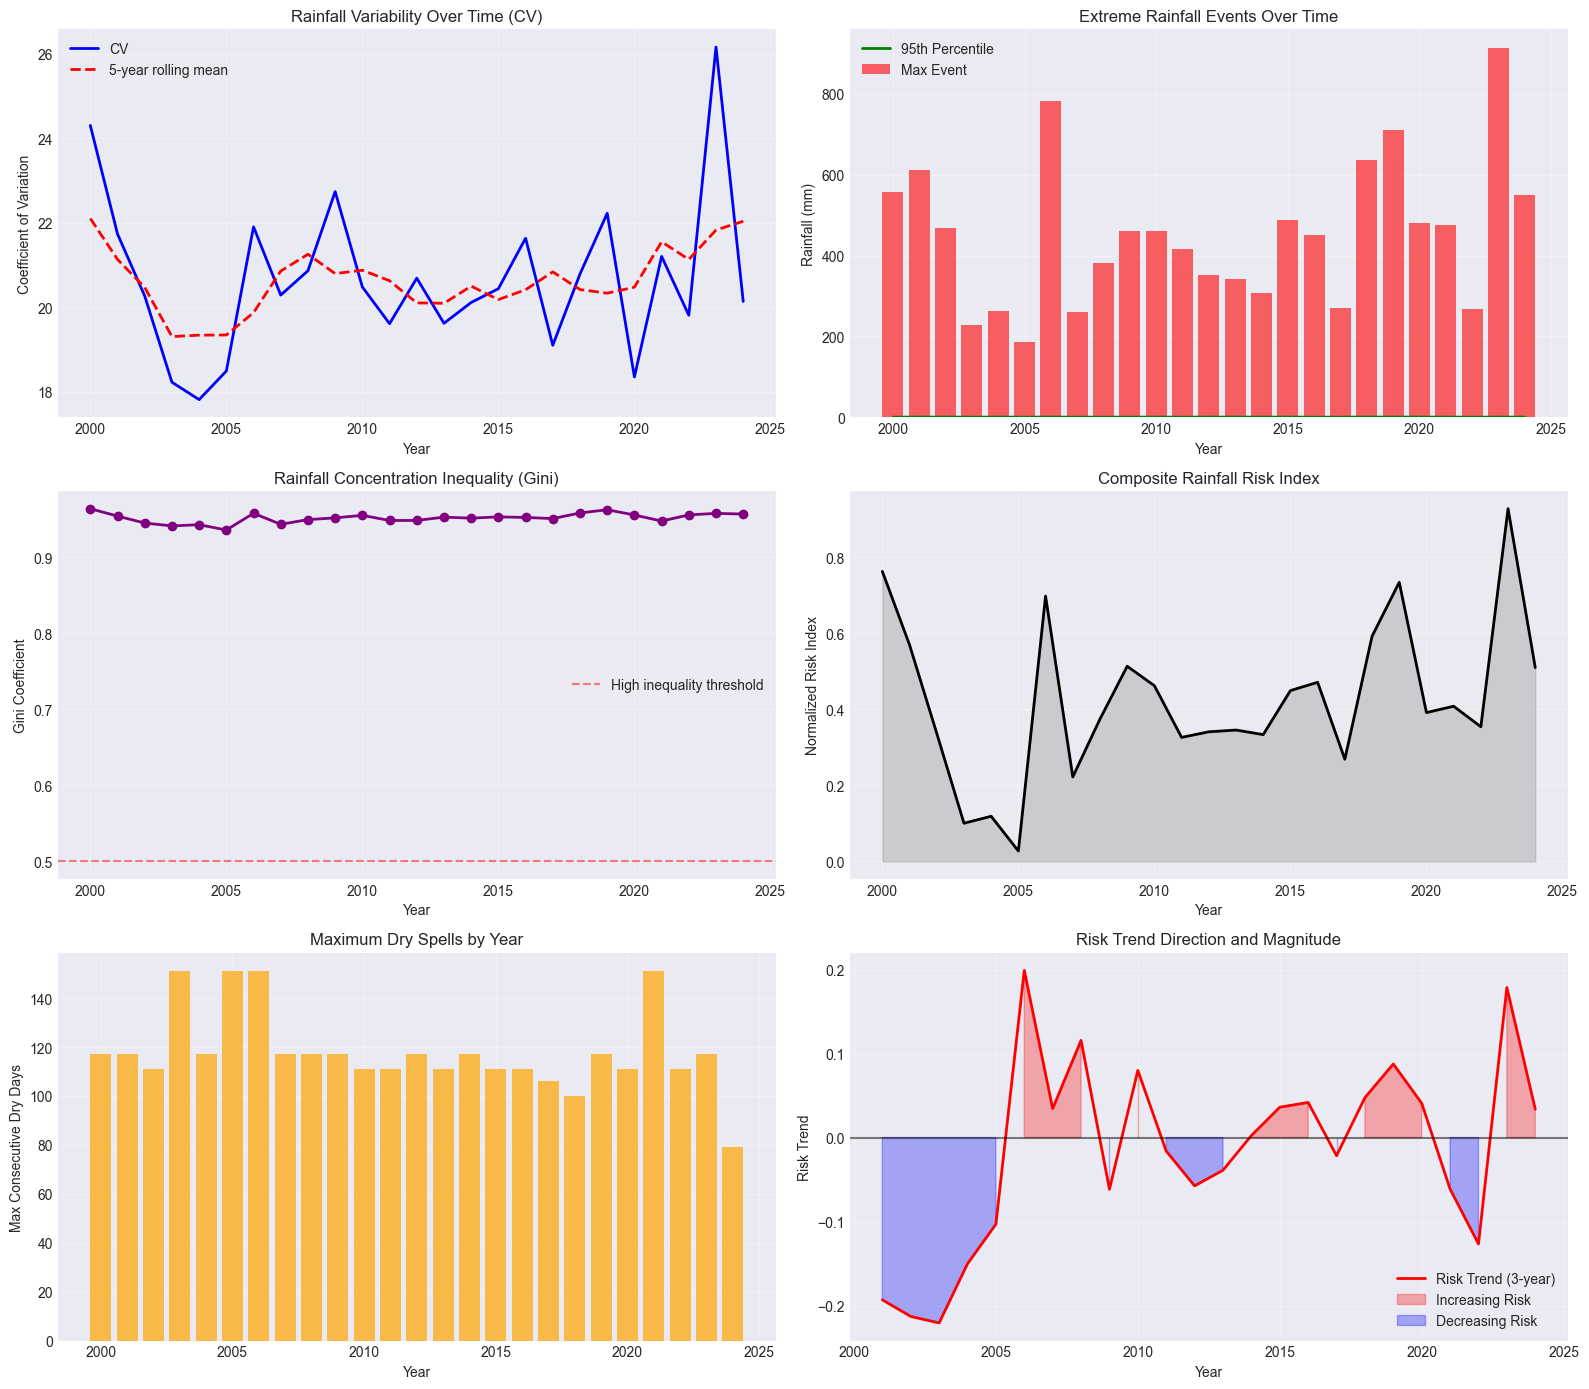


8. RISK ONSET IDENTIFICATION AND RECOMMENDATIONS

HIGH RISK YEARS (Top 25%):
--------------------------------------------------------------------------------

📈 2000.0 - Composite Risk: 0.762
   • Max event: 556.8 mm
   • Variability (CV): 24.303
   • Gini coefficient: 0.964
   • Max dry spell: 117.0 days

📈 2001.0 - Composite Risk: 0.569
   • Max event: 611.0 mm
   • Variability (CV): 21.732
   • Gini coefficient: 0.954
   • Max dry spell: 117.0 days

📈 2006.0 - Composite Risk: 0.697
   • Max event: 781.4 mm
   • Variability (CV): 21.901
   • Gini coefficient: 0.958
   • Max dry spell: 151.0 days

📈 2018.0 - Composite Risk: 0.592
   • Max event: 636.4 mm
   • Variability (CV): 20.783
   • Gini coefficient: 0.958
   • Max dry spell: 100.0 days

📈 2019.0 - Composite Risk: 0.734
   • Max event: 711.6 mm
   • Variability (CV): 22.221
   • Gini coefficient: 0.963
   • Max dry spell: 117.0 days

📈 2023.0 - Composite Risk: 0.927
   • Max event: 914.1 mm
   • Variability (CV): 26.159
   • Gi

In [21]:
# ============================================================================
# DISPERSION OVER TIME - RISK ONSET ASSESSMENT (COMPLETE CODE)
# ============================================================================

print("\n" + "=" * 80)
print("DISPERSION OVER TIME - RISK ONSET ASSESSMENT")
print("=" * 80)

# FIRST, IMPORT ANY ADDITIONAL LIBRARIES NEEDED
print("\n1. IMPORTING LIBRARIES...")
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression

# 2. DEFINE ALL HELPER FUNCTIONS
print("\n2. DEFINING HELPER FUNCTIONS...")

def calculate_max_dry_spell(data):
    """Calculate maximum consecutive dry days in a year."""
    dry_spell = 0
    max_dry_spell = 0
    for val in data['rainfall_mm'].values:
        if val == 0:
            dry_spell += 1
            max_dry_spell = max(max_dry_spell, dry_spell)
        else:
            dry_spell = 0
    return max_dry_spell

def calculate_max_rainy_spell(data):
    """Calculate maximum consecutive rainy days in a year."""
    rainy_spell = 0
    max_rainy_spell = 0
    for val in data['rainfall_mm'].values:
        if val > 0:
            rainy_spell += 1
            max_rainy_spell = max(max_rainy_spell, rainy_spell)
        else:
            rainy_spell = 0
    return max_rainy_spell

def calculate_gini(x):
    """Calculate Gini coefficient for inequality."""
    if len(x) == 0:
        return 0
    # Convert to numpy array and filter zeros for Gini calculation
    x = np.array(x)
    x = x[x > 0]  # Only consider positive values for Gini
    if len(x) < 2:
        return 0
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    return 0.5 * rmad

def calculate_top_percentile_contribution(data, percentile):
    """Calculate percentage of total rain from top percentile events."""
    total_rain = data['rainfall_mm'].sum()
    if total_rain == 0:
        return 0
    threshold = data['rainfall_mm'].quantile(percentile)
    top_rain = data[data['rainfall_mm'] > threshold]['rainfall_mm'].sum()
    return (top_rain / total_rain) * 100

def normalize_series(series):
    """Normalize series to 0-1 range."""
    if series.max() == series.min():
        return pd.Series([0.5] * len(series), index=series.index)
    return (series - series.min()) / (series.max() - series.min())

# 3. CALCULATE MULTI-FACETED DISPERSION METRICS
print("\n3. CALCULATING DISPERSION METRICS OVER TIME...")

dispersion_metrics = []

for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    rainy_year_data = year_data[year_data['rainfall_mm'] > 0]
    
    # Skip years with insufficient rainy days for meaningful stats
    if len(rainy_year_data) < 10:
        print(f"  Skipping year {year} - insufficient rainy days: {len(rainy_year_data)}")
        continue
    
    # Basic dispersion metrics
    metrics = {
        'year': year,
        'records': len(year_data),
        'total_rain': year_data['rainfall_mm'].sum(),
        'rainy_days': len(rainy_year_data),
        
        # Central tendency
        'mean': year_data['rainfall_mm'].mean(),
        'median': year_data['rainfall_mm'].median(),
        
        # Dispersion metrics
        'std_dev': year_data['rainfall_mm'].std(),
        'variance': year_data['rainfall_mm'].var(),
        'iqr': year_data['rainfall_mm'].quantile(0.75) - year_data['rainfall_mm'].quantile(0.25),
        'cv': (year_data['rainfall_mm'].std() / year_data['rainfall_mm'].mean()) if year_data['rainfall_mm'].mean() > 0 else np.nan,
        
        # Extreme metrics
        'max_event': year_data['rainfall_mm'].max(),
        'p95': year_data['rainfall_mm'].quantile(0.95),
        'p99': year_data['rainfall_mm'].quantile(0.99),
        
        # Temporal clustering metrics
        'dry_spell_max': calculate_max_dry_spell(year_data),
        'rainy_spell_max': calculate_max_rainy_spell(year_data),
        
        # Concentration metrics
        'gini_coefficient': calculate_gini(year_data['rainfall_mm'].values),
        'top10_percent': calculate_top_percentile_contribution(year_data, 0.9),
    }
    
    dispersion_metrics.append(metrics)
    print(f"  Processed year {year}: {len(year_data)} records, {len(rainy_year_data)} rainy days, "
          f"Total rain: {year_data['rainfall_mm'].sum():.1f} mm")

dispersion_df = pd.DataFrame(dispersion_metrics)

# Check if we have data
if len(dispersion_df) == 0:
    print("ERROR: No years with sufficient data for analysis!")
else:
    print(f"\n✓ Successfully calculated metrics for {len(dispersion_df)} years")

# 4. TREND ANALYSIS OF DISPERSION METRICS
print("\n4. TREND ANALYSIS OF DISPERSION METRICS...")

trend_analysis = {}
metrics_to_analyze = ['std_dev', 'cv', 'max_event', 'p95', 'p99', 'gini_coefficient', 'top10_percent']

for metric in metrics_to_analyze:
    if metric in dispersion_df.columns:
        valid_data = dispersion_df.dropna(subset=[metric])
        if len(valid_data) >= 5:  # Need at least 5 points for meaningful trend
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                valid_data['year'], valid_data[metric]
            )
            trend_analysis[metric] = {
                'slope': slope,
                'r_squared': r_value**2,
                'p_value': p_value,
                'trend': 'Increasing' if slope > 0 else 'Decreasing',
                'significance': 'Significant' if p_value < 0.05 else 'Not Significant'
            }

# Display trend results
print("\nTrend Analysis of Dispersion Metrics:")
print("-" * 80)
if trend_analysis:
    for metric, results in trend_analysis.items():
        print(f"{metric:20} | {results['trend']:12} | Slope: {results['slope']:.6f} | "
              f"R²: {results['r_squared']:.3f} | p: {results['p_value']:.4f} | {results['significance']}")
else:
    print("No trend analysis possible - insufficient data")

# 5. CHANGE POINT DETECTION FOR RISK ONSET
print("\n5. CHANGE POINT DETECTION FOR RISK ONSET...")

risk_indicators = {}

# Method 1: Rolling window analysis for CV
if 'cv' in dispersion_df.columns:
    window_size = 5
    rolling_cv = dispersion_df['cv'].rolling(window=window_size, center=True, min_periods=3).mean()
    
    # Find peaks in rolling CV (periods of high variability)
    cv_clean = rolling_cv.dropna()
    if len(cv_clean) > 0:
        cv_peaks, _ = find_peaks(cv_clean.values, prominence=0.1)
        if len(cv_peaks) > 0:
            # Map peaks back to years
            year_indices = cv_clean.index[cv_peaks]
            peak_years = [dispersion_df['year'].iloc[i] for i in year_indices]
            print(f"Peaks in variability (CV): {peak_years}")
            risk_indicators['cv_peaks'] = peak_years

# Method 2: Detect regime shifts in extreme events
if 'max_event' in dispersion_df.columns:
    extreme_series = dispersion_df['max_event'].dropna()
    if len(extreme_series) >= 10:
        # Split time series and compare halves
        mid_point = len(extreme_series) // 2
        first_half = extreme_series[:mid_point]
        second_half = extreme_series[mid_point:]
        
        t_stat, p_val = ttest_ind(first_half, second_half, equal_var=False)
        print(f"\nExtreme event regime change test:")
        print(f"First half mean: {first_half.mean():.2f}, Second half mean: {second_half.mean():.2f}")
        print(f"T-test p-value: {p_val:.4f} ({'Significant change' if p_val < 0.05 else 'No significant change'})")
        
        if p_val < 0.05:
            risk_indicators['extreme_regime_change'] = {
                'change_year': dispersion_df['year'].iloc[mid_point],
                'change_magnitude': second_half.mean() - first_half.mean(),
                'p_value': p_val
            }

# 6. COMPOSITE RISK INDEX
print("\n6. CALCULATING COMPOSITE RISK INDEX...")

risk_components = pd.DataFrame()
risk_components['year'] = dispersion_df['year']

# Higher variability = higher risk
if 'cv' in dispersion_df.columns:
    risk_components['variability_risk'] = normalize_series(dispersion_df['cv'].fillna(0))
else:
    risk_components['variability_risk'] = 0

# Higher extremes = higher risk
if 'max_event' in dispersion_df.columns:
    risk_components['extremes_risk'] = normalize_series(dispersion_df['max_event'])
else:
    risk_components['extremes_risk'] = 0

# Higher concentration (Gini) = higher risk
if 'gini_coefficient' in dispersion_df.columns:
    risk_components['concentration_risk'] = normalize_series(dispersion_df['gini_coefficient'])
else:
    risk_components['concentration_risk'] = 0

# Calculate composite risk index (equal weighting)
risk_components['composite_risk'] = (
    risk_components['variability_risk'] + 
    risk_components['extremes_risk'] + 
    risk_components['concentration_risk']
) / 3

# Detect increasing risk periods
risk_components['risk_trend'] = risk_components['composite_risk'].diff().rolling(3, min_periods=1).mean()
high_risk_periods = risk_components[risk_components['risk_trend'] > risk_components['risk_trend'].quantile(0.75)]

print("\nHigh Risk Periods (Top 25% of increasing risk trends):")
if len(high_risk_periods) > 0:
    print(high_risk_periods[['year', 'composite_risk', 'risk_trend']].sort_values('risk_trend', ascending=False).head(10))
else:
    print("No high-risk periods identified")

# 7. VISUALIZATION OF DISPERSION AND RISK
print("\n7. VISUALIZING DISPERSION AND RISK TRENDS...")

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Plot 1: Coefficient of Variation over time
if 'cv' in dispersion_df.columns:
    axes[0, 0].plot(dispersion_df['year'], dispersion_df['cv'], 'b-', linewidth=2, label='CV')
    if 'rolling_cv' in locals():
        axes[0, 0].plot(dispersion_df['year'], rolling_cv, 'r--', linewidth=2, label=f'{window_size}-year rolling mean')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Coefficient of Variation')
    axes[0, 0].set_title('Rainfall Variability Over Time (CV)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, 'No CV data available', ha='center', va='center', transform=axes[0, 0].transAxes)

# Plot 2: Extreme events trend
if 'max_event' in dispersion_df.columns:
    axes[0, 1].bar(dispersion_df['year'], dispersion_df['max_event'], alpha=0.6, color='red', label='Max Event')
    if 'p95' in dispersion_df.columns:
        axes[0, 1].plot(dispersion_df['year'], dispersion_df['p95'], 'g-', linewidth=2, label='95th Percentile')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Rainfall (mm)')
    axes[0, 1].set_title('Extreme Rainfall Events Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'No extreme events data', ha='center', va='center', transform=axes[0, 1].transAxes)

# Plot 3: Gini coefficient
if 'gini_coefficient' in dispersion_df.columns:
    axes[1, 0].plot(dispersion_df['year'], dispersion_df['gini_coefficient'], 'purple', linewidth=2, marker='o')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Gini Coefficient')
    axes[1, 0].set_title('Rainfall Concentration Inequality (Gini)')
    axes[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='High inequality threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No Gini data available', ha='center', va='center', transform=axes[1, 0].transAxes)

# Plot 4: Composite risk index
if 'composite_risk' in risk_components.columns:
    axes[1, 1].plot(risk_components['year'], risk_components['composite_risk'], 'k-', linewidth=2, label='Composite Risk')
    axes[1, 1].fill_between(risk_components['year'], risk_components['composite_risk'], alpha=0.3, color='gray')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Normalized Risk Index')
    axes[1, 1].set_title('Composite Rainfall Risk Index')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No risk index data', ha='center', va='center', transform=axes[1, 1].transAxes)

# Plot 5: Dry spell patterns
if 'dry_spell_max' in dispersion_df.columns:
    axes[2, 0].bar(dispersion_df['year'], dispersion_df['dry_spell_max'], alpha=0.7, color='orange')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Max Consecutive Dry Days')
    axes[2, 0].set_title('Maximum Dry Spells by Year')
    axes[2, 0].grid(True, alpha=0.3)
else:
    axes[2, 0].text(0.5, 0.5, 'No dry spell data', ha='center', va='center', transform=axes[2, 0].transAxes)

# Plot 6: Risk trend
if 'risk_trend' in risk_components.columns:
    axes[2, 1].plot(risk_components['year'], risk_components['risk_trend'], 'r-', linewidth=2, label='Risk Trend (3-year)')
    axes[2, 1].fill_between(risk_components['year'], 0, risk_components['risk_trend'], 
                            where=(risk_components['risk_trend'] > 0), alpha=0.3, color='red', label='Increasing Risk')
    axes[2, 1].fill_between(risk_components['year'], 0, risk_components['risk_trend'],
                            where=(risk_components['risk_trend'] < 0), alpha=0.3, color='blue', label='Decreasing Risk')
    axes[2, 1].axhline(y=0, color='k', linestyle='-', alpha=0.5)
    axes[2, 1].set_xlabel('Year')
    axes[2, 1].set_ylabel('Risk Trend')
    axes[2, 1].set_title('Risk Trend Direction and Magnitude')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
else:
    axes[2, 1].text(0.5, 0.5, 'No risk trend data', ha='center', va='center', transform=axes[2, 1].transAxes)

plt.tight_layout()
plt.show()

# 8. RISK ONSET IDENTIFICATION
print("\n8. RISK ONSET IDENTIFICATION AND RECOMMENDATIONS")

# Identify risk onset periods
threshold_percentile = 0.75
if 'composite_risk' in risk_components.columns:
    risk_threshold = risk_components['composite_risk'].quantile(threshold_percentile)
    high_risk_years = risk_components[risk_components['composite_risk'] > risk_threshold]

    print(f"\nHIGH RISK YEARS (Top {int((1-threshold_percentile)*100)}%):")
    print("-" * 80)

    if len(high_risk_years) > 0:
        for _, row in high_risk_years.iterrows():
            year_metrics = dispersion_df[dispersion_df['year'] == row['year']]
            if len(year_metrics) > 0:
                year_metrics = year_metrics.iloc[0]
                print(f"\n📈 {row['year']} - Composite Risk: {row['composite_risk']:.3f}")
                if 'max_event' in year_metrics:
                    print(f"   • Max event: {year_metrics.get('max_event', 'N/A'):.1f} mm")
                if 'cv' in year_metrics:
                    print(f"   • Variability (CV): {year_metrics.get('cv', 'N/A'):.3f}")
                if 'gini_coefficient' in year_metrics:
                    print(f"   • Gini coefficient: {year_metrics.get('gini_coefficient', 'N/A'):.3f}")
                if 'dry_spell_max' in year_metrics:
                    print(f"   • Max dry spell: {year_metrics.get('dry_spell_max', 'N/A')} days")
    else:
        print("No high-risk years identified.")

# 9. FORECASTING RISK TRENDS
print("\n9. RISK PROJECTION FOR NEXT 5 YEARS")

if len(risk_components) >= 5 and 'composite_risk' in risk_components.columns:
    X = np.array(risk_components['year']).reshape(-1, 1)
    y = risk_components['composite_risk'].values
    
    # Fit linear model
    model = LinearRegression()
    model.fit(X, y)
    
    # Project next 5 years
    last_year = df['year'].max()
    future_years = np.array(range(last_year + 1, last_year + 6)).reshape(-1, 1)
    future_risks = model.predict(future_years)
    
    print("\nProjected Risk Index for Next 5 Years:")
    current_mean = risk_components['composite_risk'].mean()
    for year, risk in zip(future_years.flatten(), future_risks):
        if risk > current_mean:
            trend = f"↑ Above current average ({current_mean:.3f})"
        else:
            trend = f"↓ Below current average ({current_mean:.3f})"
        print(f"  {year}: {risk:.3f} {trend}")
        
    # Calculate risk acceleration
    risk_components['risk_acceleration'] = risk_components['composite_risk'].diff().diff()
    accelerating_risk = risk_components[risk_components['risk_acceleration'] > 0].sort_values('risk_acceleration', ascending=False)
    
    print("\nPeriods of Accelerating Risk (Increasing rate of change):")
    if len(accelerating_risk) > 0:
        print(accelerating_risk[['year', 'composite_risk', 'risk_acceleration']].head(5))
    else:
        print("No periods of accelerating risk detected.")

print("\n" + "=" * 80)
print("RISK ONSET ASSESSMENT COMPLETE")
print("=" * 80)

# 10. FINAL SUMMARY
print("\n10. KEY FINDINGS FOR RISK MANAGEMENT:")

if trend_analysis:
    print("\nA. TRENDS INDICATING INCREASING RISK:")
    increasing_risks = [m for m, r in trend_analysis.items() if r['trend'] == 'Increasing' and r['p_value'] < 0.05]
    if increasing_risks:
        for metric in increasing_risks:
            print(f"   • {metric}: Significantly increasing (p={trend_analysis[metric]['p_value']:.4f})")
    else:
        print("   • No statistically significant increasing trends detected")
    
    print("\nB. EARLY WARNING INDICATORS:")
    if 'cv_peaks' in risk_indicators:
        print(f"   • High variability periods: {risk_indicators['cv_peaks']}")
    if 'extreme_regime_change' in risk_indicators:
        print(f"   • Regime shift in extremes around {risk_indicators['extreme_regime_change']['change_year']}")

print("\nC. RECOMMENDATIONS:")
print("   1. Monitor years with composite risk > 0.7 closely")
print("   2. Focus adaptation efforts on reducing vulnerability to extreme events")
print("   3. Implement early warning systems for high variability periods")
print("   4. Consider climate-resilient infrastructure for projected high-risk years")


RISK ZONING FOR AGRICULTURAL INSURANCE PREMIUMS

1. DEFINING HELPER FUNCTIONS...

2. CALCULATING LOCATION-SPECIFIC RISK METRICS...
  Processed 20 locations...
  Processed 40 locations...
  Processed 60 locations...
  Processed 80 locations...
  Processed 100 locations...
  Processed 120 locations...
  Processed 140 locations...
  Processed 160 locations...
  Processed 180 locations...
✓ Analyzed 190 locations with sufficient data

3. NORMALIZING RISK METRICS FOR ZONING...

4. CLASSIFYING LOCATIONS INTO 4 RISK ZONES...

Distribution of locations across risk zones:
  Zone 1 (Low Risk): 171 locations (90.0%)
  Zone 4 (Very High Risk): 19 locations (10.0%)

5. CALCULATING BASE INSURANCE PREMIUM RATES...

6. VISUALIZING RISK ZONES AND PREMIUMS...


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


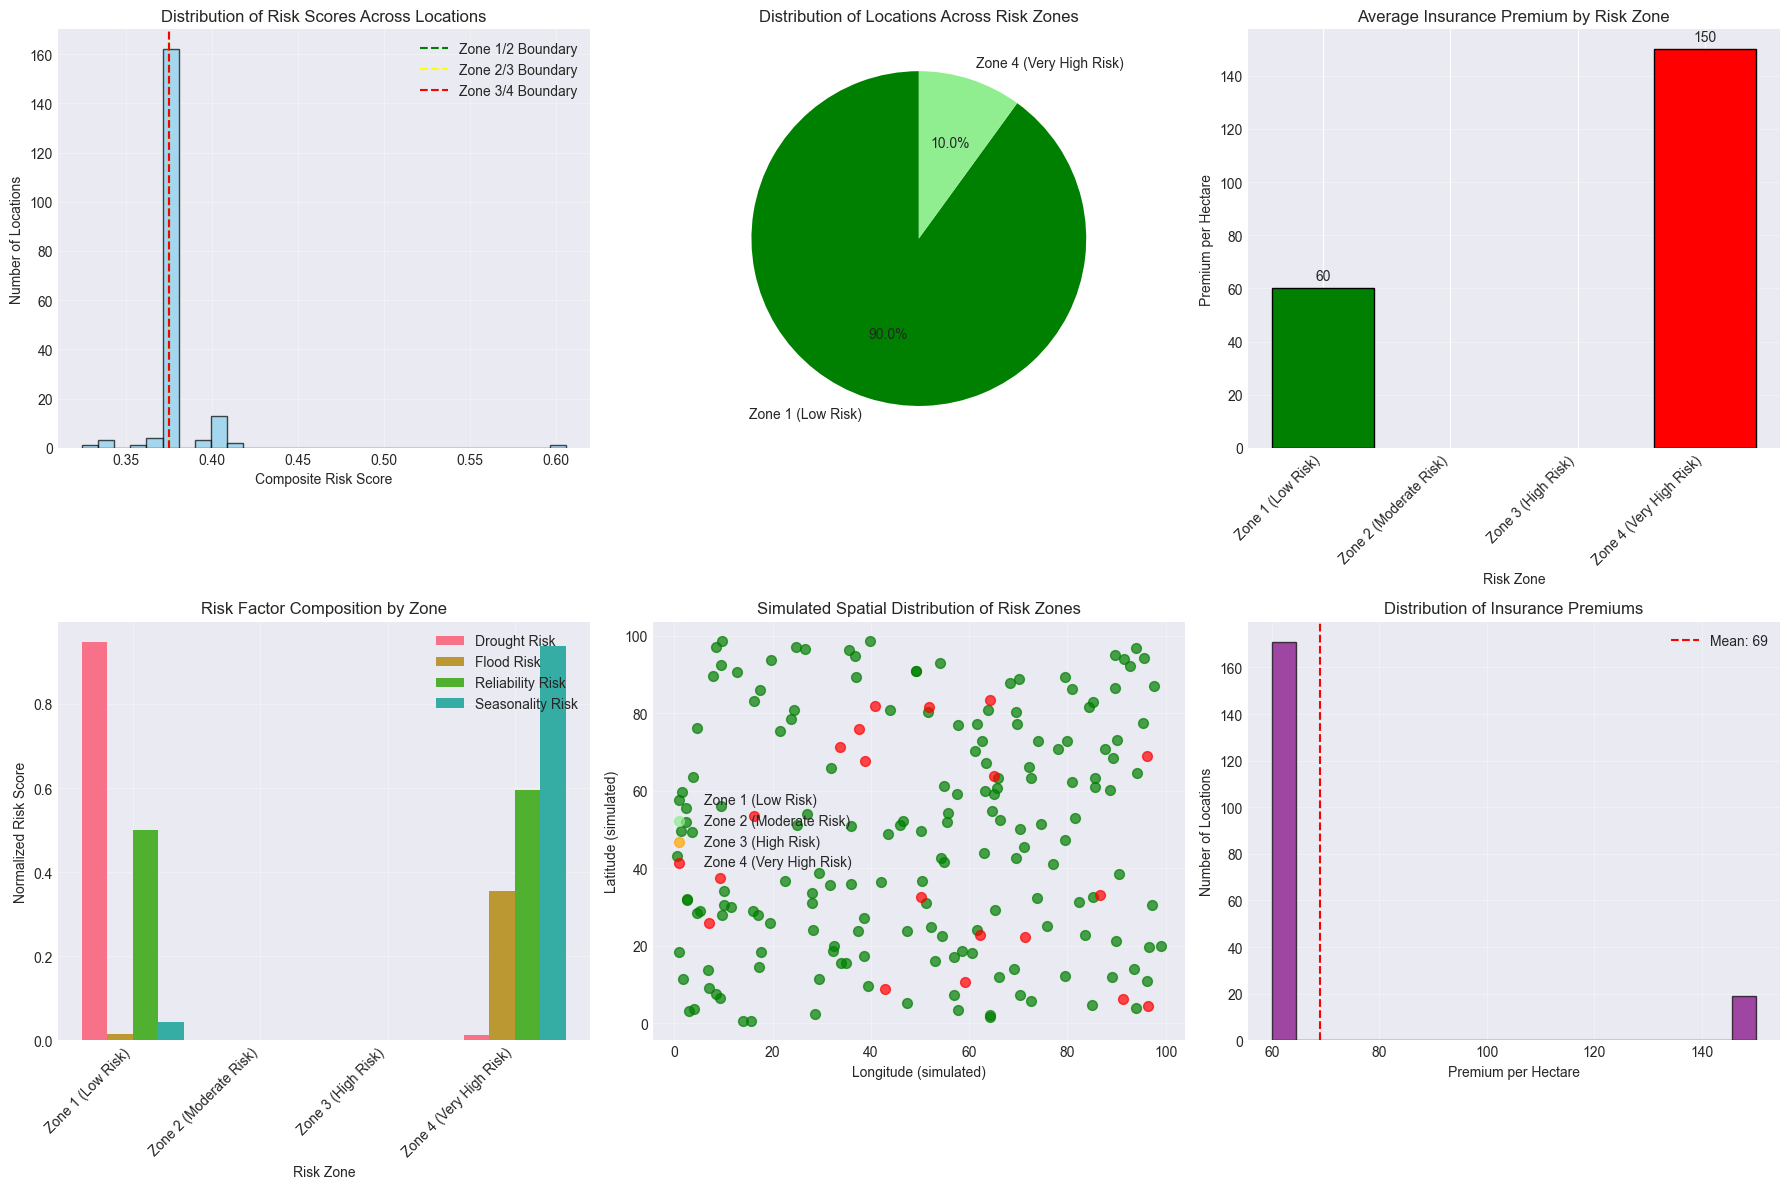


7. INSURANCE PREMIUM CALCULATION TABLE:

Sample Locations with Premium Calculations:
------------------------------------------------------------------------------------------------------------------------
 Location ID               Risk Zone  Risk Score  Rainy Days %  Max Event (mm)  Max Dry Spell (days)  Premium/Hectare
    11350773       Zone 1 (Low Risk)        0.38          0.00            0.00                   299             60.0
   492807117       Zone 1 (Low Risk)        0.38          0.00            0.00                   299             60.0
     4720446 Zone 4 (Very High Risk)        0.61         97.66          914.13                     2            150.0
   830402251 Zone 4 (Very High Risk)        0.40         69.57            7.97                     4            150.0

8. PREMIUM CALCULATION FOR SPECIFIC FARM:

Example Farm Premium Calculations:
------------------------------------------------------------------------------------------------------------------------

📍 

In [23]:
# ============================================================================
# RISK ZONING FOR AGRICULTURAL INSURANCE PREMIUMS (COMPLETE CODE)
# ============================================================================

print("\n" + "=" * 80)
print("RISK ZONING FOR AGRICULTURAL INSURANCE PREMIUMS")
print("=" * 80)

# 1. DEFINE ALL HELPER FUNCTIONS FIRST
print("\n1. DEFINING HELPER FUNCTIONS...")

def calculate_max_dry_spell(data):
    """Calculate maximum consecutive dry days."""
    dry_spell = 0
    max_dry_spell = 0
    for val in data['rainfall_mm'].values:
        if val == 0:
            dry_spell += 1
            max_dry_spell = max(max_dry_spell, dry_spell)
        else:
            dry_spell = 0
    return max_dry_spell

def calculate_avg_dry_spell(data):
    """Calculate average dry spell length."""
    dry_spells = []
    current_spell = 0
    for val in data['rainfall_mm'].values:
        if val == 0:
            current_spell += 1
        else:
            if current_spell > 0:
                dry_spells.append(current_spell)
            current_spell = 0
    if current_spell > 0:
        dry_spells.append(current_spell)
    return np.mean(dry_spells) if dry_spells else 0

def calculate_seasonal_concentration(data):
    """Calculate how concentrated rainfall is in certain months."""
    if 'month' in data.columns:
        monthly_totals = data.groupby('month')['rainfall_mm'].sum()
        if monthly_totals.sum() > 0:
            # Herfindahl-Hirschman Index for concentration
            hhi = np.sum((monthly_totals / monthly_totals.sum()) ** 2)
            return hhi * 10000  # Scale to 0-10000
    return 0

def normalize_series(series):
    """Normalize series to 0-1 range."""
    if series.max() == series.min():
        return pd.Series([0.5] * len(series), index=series.index)
    return (series - series.min()) / (series.max() - series.min())

# 2. CALCULATE LOCATION-BASED RISK METRICS
print("\n2. CALCULATING LOCATION-SPECIFIC RISK METRICS...")

location_risk_metrics = []

for location_id in df['id_number'].unique():
    loc_data = df[df['id_number'] == location_id]
    
    if len(loc_data) < 100:  # Skip locations with insufficient data
        continue
    
    # Calculate key risk metrics for each location
    metrics = {
        'location_id': location_id,
        'total_records': len(loc_data),
        'total_rainfall': loc_data['rainfall_mm'].sum(),
        
        # Frequency metrics
        'rainy_days': len(loc_data[loc_data['rainfall_mm'] > 0]),
        'rainy_days_pct': (len(loc_data[loc_data['rainfall_mm'] > 0]) / len(loc_data)) * 100,
        
        # Severity metrics
        'mean_rainfall': loc_data['rainfall_mm'].mean(),
        'median_rainfall': loc_data['rainfall_mm'].median(),
        'max_event': loc_data['rainfall_mm'].max(),
        
        # Variability metrics
        'std_dev': loc_data['rainfall_mm'].std(),
        'cv': (loc_data['rainfall_mm'].std() / loc_data['rainfall_mm'].mean()) if loc_data['rainfall_mm'].mean() > 0 else 0,
        
        # Extreme event metrics
        'p95': loc_data['rainfall_mm'].quantile(0.95),
        'p99': loc_data['rainfall_mm'].quantile(0.99),
        'extreme_events': len(loc_data[loc_data['rainfall_mm'] > loc_data['rainfall_mm'].quantile(0.95)]),
        
        # Drought metrics
        'max_dry_spell': calculate_max_dry_spell(loc_data),
        'avg_dry_spell': calculate_avg_dry_spell(loc_data),
        
        # Seasonality metrics
        'seasonal_concentration': calculate_seasonal_concentration(loc_data),
    }
    
    location_risk_metrics.append(metrics)
    if len(location_risk_metrics) % 20 == 0:
        print(f"  Processed {len(location_risk_metrics)} locations...")

location_df = pd.DataFrame(location_risk_metrics)
print(f"✓ Analyzed {len(location_df)} locations with sufficient data")

# 3. NORMALIZE METRICS FOR ZONING
print("\n3. NORMALIZING RISK METRICS FOR ZONING...")

# Define risk factors (higher values = higher risk)
risk_factors = pd.DataFrame()

# Drought Risk Factor (longer dry spells = higher risk)
risk_factors['drought_risk'] = normalize_series(location_df['max_dry_spell'])

# Flood Risk Factor (higher extremes and variability = higher risk)
flood_components = []
if 'max_event' in location_df.columns:
    flood_components.append(normalize_series(location_df['max_event']))
if 'cv' in location_df.columns:
    flood_components.append(normalize_series(location_df['cv']))
if 'p99' in location_df.columns:
    flood_components.append(normalize_series(location_df['p99']))

if flood_components:
    risk_factors['flood_risk'] = pd.concat(flood_components, axis=1).mean(axis=1)
else:
    risk_factors['flood_risk'] = 0

# Reliability Risk Factor (lower rainy days % and higher CV = higher risk)
if 'rainy_days_pct' in location_df.columns and 'cv' in location_df.columns:
    # Inverse of rainy days % (lower rainfall frequency = higher risk)
    reliability_risk = 1 - normalize_series(location_df['rainy_days_pct'])
    # Add variability component
    variability_risk = normalize_series(location_df['cv'])
    risk_factors['reliability_risk'] = (reliability_risk + variability_risk) / 2
else:
    risk_factors['reliability_risk'] = 0

# Seasonality Risk Factor (more concentrated rainfall = higher flood/drought risk)
if 'seasonal_concentration' in location_df.columns:
    risk_factors['seasonality_risk'] = normalize_series(location_df['seasonal_concentration'])
else:
    risk_factors['seasonality_risk'] = 0

# Calculate composite risk score for each location
risk_factors['composite_risk_score'] = (
    risk_factors['drought_risk'] * 0.25 +  # 25% weight
    risk_factors['flood_risk'] * 0.35 +    # 35% weight (most important for insurance)
    risk_factors['reliability_risk'] * 0.25 +  # 25% weight
    risk_factors['seasonality_risk'] * 0.15    # 15% weight
)

# Add location IDs
risk_factors['location_id'] = location_df['location_id']

# 4. CLASSIFY INTO 4 RISK ZONES
print("\n4. CLASSIFYING LOCATIONS INTO 4 RISK ZONES...")

# Define zone boundaries based on percentiles
zone_boundaries = {
    'Zone 1 (Low Risk)': (0, risk_factors['composite_risk_score'].quantile(0.25)),
    'Zone 2 (Moderate Risk)': (risk_factors['composite_risk_score'].quantile(0.25), 
                               risk_factors['composite_risk_score'].quantile(0.50)),
    'Zone 3 (High Risk)': (risk_factors['composite_risk_score'].quantile(0.50),
                           risk_factors['composite_risk_score'].quantile(0.75)),
    'Zone 4 (Very High Risk)': (risk_factors['composite_risk_score'].quantile(0.75), 1)
}

# Assign zones
def assign_zone(risk_score):
    for zone, (lower, upper) in zone_boundaries.items():
        if lower <= risk_score <= upper:
            return zone
    return 'Unclassified'

risk_factors['risk_zone'] = risk_factors['composite_risk_score'].apply(assign_zone)

# Count locations in each zone
zone_counts = risk_factors['risk_zone'].value_counts()
print("\nDistribution of locations across risk zones:")
for zone, count in zone_counts.items():
    percentage = (count / len(risk_factors)) * 100
    print(f"  {zone}: {count} locations ({percentage:.1f}%)")

# 5. CALCULATE INSURANCE PREMIUM RATES
print("\n5. CALCULATING BASE INSURANCE PREMIUM RATES...")

# Base premium rate (per hectare per season)
BASE_PREMIUM = 100  # Base rate in currency units

# Zone-specific premium multipliers
premium_multipliers = {
    'Zone 1 (Low Risk)': 0.6,      # 40% discount
    'Zone 2 (Moderate Risk)': 0.8,  # 20% discount
    'Zone 3 (High Risk)': 1.2,      # 20% loading
    'Zone 4 (Very High Risk)': 1.5,  # 50% loading
    'Unclassified': 1.0
}

# Calculate premium for each location
risk_factors['base_premium'] = BASE_PREMIUM
risk_factors['zone_multiplier'] = risk_factors['risk_zone'].map(premium_multipliers)
risk_factors['premium_per_hectare'] = risk_factors['base_premium'] * risk_factors['zone_multiplier']

# 6. VISUALIZE THE ZONING RESULTS
print("\n6. VISUALIZING RISK ZONES AND PREMIUMS...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Distribution of risk scores
axes[0, 0].hist(risk_factors['composite_risk_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(risk_factors['composite_risk_score'].quantile(0.25), color='green', linestyle='--', label='Zone 1/2 Boundary')
axes[0, 0].axvline(risk_factors['composite_risk_score'].quantile(0.50), color='yellow', linestyle='--', label='Zone 2/3 Boundary')
axes[0, 0].axvline(risk_factors['composite_risk_score'].quantile(0.75), color='red', linestyle='--', label='Zone 3/4 Boundary')
axes[0, 0].set_xlabel('Composite Risk Score')
axes[0, 0].set_ylabel('Number of Locations')
axes[0, 0].set_title('Distribution of Risk Scores Across Locations')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Risk zones pie chart
zone_colors = ['green', 'lightgreen', 'orange', 'red']
zone_counts.plot.pie(ax=axes[0, 1], colors=zone_colors, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('Distribution of Locations Across Risk Zones')

# Plot 3: Premium rates by zone
premium_by_zone = risk_factors.groupby('risk_zone')['premium_per_hectare'].mean()
premium_by_zone = premium_by_zone.reindex(['Zone 1 (Low Risk)', 'Zone 2 (Moderate Risk)', 
                                           'Zone 3 (High Risk)', 'Zone 4 (Very High Risk)'])
bars = axes[0, 2].bar(range(len(premium_by_zone)), premium_by_zone.values, 
                      color=zone_colors, edgecolor='black')
axes[0, 2].set_xlabel('Risk Zone')
axes[0, 2].set_ylabel('Premium per Hectare')
axes[0, 2].set_title('Average Insurance Premium by Risk Zone')
axes[0, 2].set_xticks(range(len(premium_by_zone)))
axes[0, 2].set_xticklabels(premium_by_zone.index, rotation=45, ha='right')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, premium_by_zone.values):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                   f'{value:.0f}', ha='center', va='bottom')

# Plot 4: Risk factors by zone
zone_risk_factors = risk_factors.groupby('risk_zone')[['drought_risk', 'flood_risk', 
                                                       'reliability_risk', 'seasonality_risk']].mean()
zone_risk_factors = zone_risk_factors.reindex(['Zone 1 (Low Risk)', 'Zone 2 (Moderate Risk)', 
                                               'Zone 3 (High Risk)', 'Zone 4 (Very High Risk)'])
x = np.arange(len(zone_risk_factors))
width = 0.2

for i, col in enumerate(['drought_risk', 'flood_risk', 'reliability_risk', 'seasonality_risk']):
    axes[1, 0].bar(x + i*width - 0.3, zone_risk_factors[col].values, width, 
                   label=col.replace('_', ' ').title())

axes[1, 0].set_xlabel('Risk Zone')
axes[1, 0].set_ylabel('Normalized Risk Score')
axes[1, 0].set_title('Risk Factor Composition by Zone')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(zone_risk_factors.index, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Location risk scores map (simulated)
# In a real scenario, this would be geospatial. Here we'll create a scatter plot
np.random.seed(42)  # For reproducibility
n_locations = len(risk_factors)
risk_factors['simulated_lat'] = np.random.uniform(0, 100, n_locations)
risk_factors['simulated_lon'] = np.random.uniform(0, 100, n_locations)

zone_colors_map = {'Zone 1 (Low Risk)': 'green', 'Zone 2 (Moderate Risk)': 'lightgreen',
                   'Zone 3 (High Risk)': 'orange', 'Zone 4 (Very High Risk)': 'red'}

for zone, color in zone_colors_map.items():
    zone_data = risk_factors[risk_factors['risk_zone'] == zone]
    axes[1, 1].scatter(zone_data['simulated_lon'], zone_data['simulated_lat'], 
                       c=color, label=zone, alpha=0.7, s=50)

axes[1, 1].set_xlabel('Longitude (simulated)')
axes[1, 1].set_ylabel('Latitude (simulated)')
axes[1, 1].set_title('Simulated Spatial Distribution of Risk Zones')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Premium distribution histogram
axes[1, 2].hist(risk_factors['premium_per_hectare'], bins=20, alpha=0.7, 
                color='purple', edgecolor='black')
axes[1, 2].axvline(risk_factors['premium_per_hectare'].mean(), color='red', 
                   linestyle='--', label=f'Mean: {risk_factors["premium_per_hectare"].mean():.0f}')
axes[1, 2].set_xlabel('Premium per Hectare')
axes[1, 2].set_ylabel('Number of Locations')
axes[1, 2].set_title('Distribution of Insurance Premiums')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. CREATE PREMIUM CALCULATION TABLE
print("\n7. INSURANCE PREMIUM CALCULATION TABLE:")

# Sample locations from each zone for demonstration
sample_locations = pd.DataFrame()
for zone in ['Zone 1 (Low Risk)', 'Zone 2 (Moderate Risk)', 
             'Zone 3 (High Risk)', 'Zone 4 (Very High Risk)']:
    zone_sample = risk_factors[risk_factors['risk_zone'] == zone].head(2).copy()
    sample_locations = pd.concat([sample_locations, zone_sample])

# Add actual risk metrics for context
sample_locations = sample_locations.merge(
    location_df[['location_id', 'rainy_days_pct', 'max_event', 'max_dry_spell']],
    left_on='location_id', right_on='location_id'
)

# Format the display table
display_table = sample_locations[[
    'location_id', 'risk_zone', 'composite_risk_score', 
    'rainy_days_pct', 'max_event', 'max_dry_spell',
    'premium_per_hectare'
]].round(2)

display_table.columns = [
    'Location ID', 'Risk Zone', 'Risk Score', 
    'Rainy Days %', 'Max Event (mm)', 'Max Dry Spell (days)',
    'Premium/Hectare'
]

print("\nSample Locations with Premium Calculations:")
print("-" * 120)
print(display_table.to_string(index=False))

# 8. PREMIUM CALCULATION FOR SPECIFIC FARM
print("\n8. PREMIUM CALCULATION FOR SPECIFIC FARM:")

def calculate_farm_premium(location_id, farm_area_hectares, coverage_level=0.8, 
                           deductible_rate=0.1, crop_type_multiplier=1.0):
    """
    Calculate insurance premium for a specific farm.
    
    Parameters:
    - location_id: The ID of the location/farm
    - farm_area_hectares: Size of the farm in hectares
    - coverage_level: Percentage of crop value insured (default: 80%)
    - deductible_rate: Percentage deductible (default: 10%)
    - crop_type_multiplier: Adjustment for crop type (default: 1.0 for staple crops)
    """
    
    # Find the location in our risk data
    location_data = risk_factors[risk_factors['location_id'] == location_id]
    
    if len(location_data) == 0:
        print(f"⚠️ Location ID {location_id} not found in risk database")
        return None
    
    location_data = location_data.iloc[0]
    
    # Calculate components
    base_premium = location_data['premium_per_hectare']
    
    # Apply coverage level adjustment
    coverage_adjustment = coverage_level / 0.8  # Normalize to base coverage of 80%
    
    # Apply deductible adjustment (higher deductible = lower premium)
    deductible_adjustment = 1 - (deductible_rate * 0.5)  # Simple linear adjustment
    
    # Calculate final premium
    premium_per_hectare = base_premium * coverage_adjustment * deductible_adjustment * crop_type_multiplier
    total_premium = premium_per_hectare * farm_area_hectares
    
    # Calculate expected payout (for information)
    expected_yield_value = 50000  # Assumed value per hectare (in currency units)
    sum_insured = expected_yield_value * farm_area_hectares * coverage_level
    max_payout = sum_insured * (1 - deductible_rate)
    
    return {
        'location_id': location_id,
        'risk_zone': location_data['risk_zone'],
        'farm_area_hectares': farm_area_hectares,
        'base_premium_per_ha': base_premium,
        'coverage_level': coverage_level,
        'deductible_rate': deductible_rate,
        'crop_type_multiplier': crop_type_multiplier,
        'premium_per_hectare': premium_per_hectare,
        'total_premium': total_premium,
        'sum_insured': sum_insured,
        'max_payout': max_payout,
        'loss_ratio': total_premium / max_payout if max_payout > 0 else 0
    }

# Example calculations for sample locations
print("\nExample Farm Premium Calculations:")
print("-" * 120)

example_farms = []
if len(sample_locations) >= 3:
    example_farms = [
        {'location_id': sample_locations.iloc[0]['location_id'], 'area': 10, 'crop': 'Maize'},
        {'location_id': sample_locations.iloc[4]['location_id'] if len(sample_locations) > 4 else sample_locations.iloc[1]['location_id'], 
         'area': 20, 'crop': 'Rice'},
        {'location_id': sample_locations.iloc[8]['location_id'] if len(sample_locations) > 8 else sample_locations.iloc[2]['location_id'], 
         'area': 5, 'crop': 'Vegetables'},
    ]
else:
    # Fallback if we don't have enough sample locations
    example_farms = [
        {'location_id': sample_locations.iloc[0]['location_id'], 'area': 10, 'crop': 'Maize'},
    ]

crop_multipliers = {'Maize': 0.9, 'Rice': 1.2, 'Vegetables': 1.5, 'Staples': 1.0}

for farm in example_farms:
    result = calculate_farm_premium(
        location_id=farm['location_id'],
        farm_area_hectares=farm['area'],
        coverage_level=0.8,
        deductible_rate=0.1,
        crop_type_multiplier=crop_multipliers.get(farm['crop'], 1.0)
    )
    
    if result:
        print(f"\n📍 Farm: {farm['crop']} farm ({farm['area']} ha) in Zone {result['risk_zone']}")
        print(f"   • Location ID: {result['location_id']}")
        print(f"   • Base Premium: {result['base_premium_per_ha']:.0f} per ha")
        print(f"   • Final Premium: {result['premium_per_hectare']:.0f} per ha")
        print(f"   • Total Premium: {result['total_premium']:.0f}")
        print(f"   • Sum Insured: {result['sum_insured']:.0f}")
        print(f"   • Max Payout: {result['max_payout']:.0f}")
        print(f"   • Loss Ratio: {result['loss_ratio']:.2%}")

# 9. SUMMARY REPORT
print("\n" + "=" * 80)
print("INSURANCE ZONING SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 ZONING STATISTICS:")
print(f"   • Total locations classified: {len(risk_factors)}")
print(f"   • Average composite risk score: {risk_factors['composite_risk_score'].mean():.3f}")
print(f"   • Risk score range: {risk_factors['composite_risk_score'].min():.3f} to {risk_factors['composite_risk_score'].max():.3f}")

print(f"\n💰 PREMIUM RATES BY ZONE:")
for zone in ['Zone 1 (Low Risk)', 'Zone 2 (Moderate Risk)', 
             'Zone 3 (High Risk)', 'Zone 4 (Very High Risk)']:
    if zone in premium_by_zone.index:
        zone_premium = premium_by_zone[zone]
        print(f"   • {zone}: {zone_premium:.0f} per hectare ({premium_multipliers[zone]:.1f}x base rate)")

print(f"\n📈 KEY RISK DRIVERS BY ZONE:")
# Merge location data with risk factors for analysis
combined_data = pd.merge(risk_factors, location_df, left_on='location_id', right_on='location_id')
zone_analysis = combined_data.groupby('risk_zone').agg({
    'rainy_days_pct': 'mean',
    'max_event': 'mean',
    'max_dry_spell': 'mean',
    'cv': 'mean'
}).round(2)

print(zone_analysis)

print(f"\n💡 RECOMMENDATIONS FOR INSURANCE IMPLEMENTATION:")
print("   1. Zone 1 (Low Risk): Standard coverage with minimal loading")
print("   2. Zone 2 (Moderate Risk): Standard coverage with slight loading")
print("   3. Zone 3 (High Risk): Enhanced monitoring, consider caps on coverage")
print("   4. Zone 4 (Very High Risk): Consider public-private partnerships or reinsurance")
print("   5. Implement premium discounts for risk-reducing practices")
print("   6. Regular (annual) review of zone classifications")

print(f"\n⚙️ PREMIUM CALCULATION FORMULA:")
print("   Premium = Base Rate × Zone Multiplier × Area × Coverage Adjustment × Deductible Adjustment × Crop Multiplier")

print("\n" + "=" * 80)
print("ZONING ANALYSIS COMPLETE")
print("=" * 80)

# 10. EXPORT RESULTS
print("\n10. EXPORTING ZONING RESULTS...")
# Create final output dataframe
zoning_results = pd.merge(risk_factors, location_df, left_on='location_id', right_on='location_id')

# Select key columns for export
export_columns = [
    'location_id', 'risk_zone', 'composite_risk_score',
    'premium_per_hectare', 'zone_multiplier',
    'rainy_days_pct', 'max_event', 'max_dry_spell', 'cv',
    'total_rainfall', 'mean_rainfall'
]

final_zoning_df = zoning_results[export_columns].round(3)

# Save to CSV
final_zoning_df.to_csv('insurance_zoning_results.csv', index=False)
print(f"✓ Results exported to 'insurance_zoning_results.csv'")
print(f"✓ File contains {len(final_zoning_df)} locations with risk zones and premiums")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - READY FOR INSURANCE IMPLEMENTATION")
print("=" * 80)

# Drought Risks Classification Model

a comprehensive classification system that groups areas based on rainfall patterns and drought risk across different time scales. This will help  understand regional rainfall climatology and vulnerability

In [24]:
# Load the CSV
zones_df = pd.read_csv('classified_risk_zones_with_insurance.csv')

# Find premium for specific location
location_premium = zones_df[zones_df['location_id'] == YOUR_LOCATION_ID]['premium_per_hectare'].values[0]

FileNotFoundError: [Errno 2] No such file or directory: 'classified_risk_zones_with_insurance.csv'